In [8]:
import scipy.io, math, os
import os
import pandas as pd, numpy as np
from help_functions import *
import torch
import matplotlib.pyplot as plt
import librosa, librosa.display

In [11]:
directory = 'data/Data/F1/mat'
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df, audio_df = [], [], [], [], [], [], []

# Go through all the ema files and append a list so each file is found in one place
for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_f1_{:03}_{:03}'.format(counter, counter + 4)]
        counter += 5
        
        for i in range(0,7):
            append_list(i)

# for each ema markers and audio you will have one dataframe which has the file code and appended file data 
merged_ul = preprocess(UL_df, 'ul')      
merged_ll = preprocess(LL_df, 'll')
merged_jw = preprocess(JW_df, 'jw')  
merged_td = preprocess(TD_df, 'td') 
merged_tb = preprocess(TB_df, 'tb') 
merged_tt = preprocess(TT_df, 'tt') 
merged_audio = preprocess_audio(audio_df) 

In [13]:
# initalise an ema list, in this append each word information in the form of dictionary
ema_frames = list()

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for line in timestamps:
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        file_code = int(split_line[0])
        
        # find start and end by multiplying the timestamps with the sampling rate for ema markers
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        ending_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # find start and end by multiplying the timestamps with the sampling rate for audio
        start_point = (math.floor(float(split_line[2]) * 22050)) - 220
        end_point = (math.ceil(float(split_line[3]) * 22050)) + 220
  
        # get data frame with all values for ema marker
        ul = get_values(UL_df, merged_ul, file_code)
        ll = get_values(LL_df, merged_ll, file_code)
        jw = get_values(JW_df, merged_jw, file_code)
        td = get_values(TD_df, merged_td, file_code)
        tb = get_values(TB_df, merged_tb, file_code)
        tt = get_values(TT_df, merged_tt, file_code)
        segment = get_values_audio(audio_df, merged_audio, file_code)
        
         # also add a key-value pair for mel spectogram
        raw_audio = segment[0]
        mel_spec = raw_audio.values
        
        # concate all dataframes with ema markers
        df_data = pd.concat([ul, ll, jw, td, tb, tt], axis = 1)
        df_data = df_data.loc[:,~df_data.columns.duplicated()]
        
        # retrieve meta data and combine with ema data into dictionary
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [sent_number],
                'file' : [file_code],
                'Data'   : [df_data],
                'Audio' : [segment],
                'Mel' : [mel_spec] } 
        
        ema_frames.append(data)

In [52]:
# [0] : first element in list, ['Audio']: access dictionary key, [0]: data as dataframe, [0]: useful row (or use: .iloc[:, 1])
ema_frames[70]['Audio'][0][0]

45832    0.002869
45833    0.001038
45834   -0.000458
45835    0.000671
45836    0.001556
           ...   
48253   -0.000336
48254   -0.000427
48255   -0.000580
48256   -0.000397
48257   -0.000244
Name: 0, Length: 2426, dtype: float64

Total data frames =  3435
Shape of Audio the 70th word =  2426


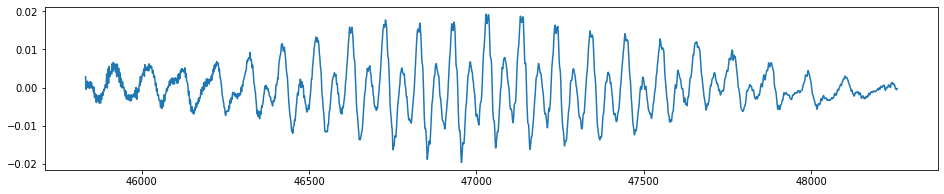

In [15]:
print("Total data frames = ", len(ema_frames))
print("Shape of Audio the 70th word = ", len(ema_frames[70]['Audio'][0][0]))

# plot wave by audio frame of first word
plt.figure(figsize=(16, 3))
plt.plot(ema_frames[70]['Audio'][0][0], '-', );

/tmp/ipykernel_1186473/1933033718.py:130: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=11025.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)


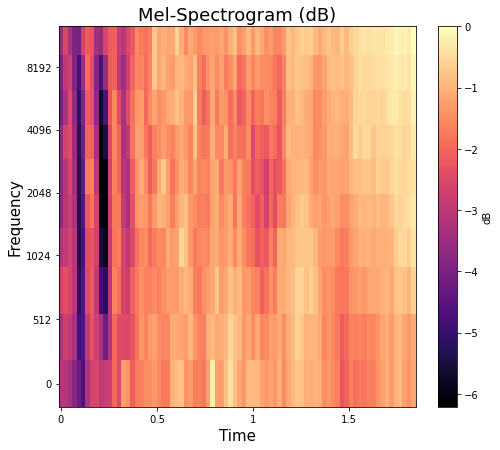

In [16]:
# test mel spectogram for word 470
test_file = ema_frames[70]['Audio'][0][0]
new_file = test_file.values

# plot the values in spectogram
mel_signal = logmelfilterbank(new_file, 22050)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(8, 7))
librosa.display.specshow(power_to_db, sr=22050, x_axis='time', y_axis='mel', cmap='magma', 
 hop_length=512)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [86]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [99]:
X, X_lens = get_features(ema_frames) # X.shape = (24783532,); max length of array = 28885

/tmp/ipykernel_1186473/884787586.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.array(features), features_length)


In [102]:
model_parameters = {
    'input_channels' : 128,                             # number of input channels 
    'output_channels' : 1024,                           # number of output channels 1st layer
    'kernel_size' : [61, 5, 3, 3],                      # kernel sizes all layers
    'stride' : [2, 1, 1, 1],
    'padding' : [30, 2, 1, 1],
    'padding_mode' : 'replicate',                       # padding mode all layers
    'drop_out' : (0.2, 0.3, 0.3)                        # droput values all layers
}

In [103]:
# FUNCTION TO ADD FILE CODE TO EMA DATA
def add_file(dataframe): 
    ''' 
        Using the list, get the index as the file code and add a new column with this index information
    '''
    for idx, frame in enumerate(dataframe):
        frame['File code'] = idx
        first_column = frame.pop('File code')
        frame.insert(0, 'File code', first_column)
        

# FUNCTION TO ADD FILE CODE TO AUDIO DATA   
def add_file_audio(dataframe): 
    ''' 
        Using the list, get the index as the file code and add a new column with this index information
    '''
    for idx, frame in enumerate(dataframe):
        data_frame = frame.insert(0, 'File Code', idx)
        
# FUNCTION FOR APPENDING LIST        
def append_list(position):
    '''
        Append the list with the mat data and return list with dataframes from each file
    '''
    if(position == 0):
        list_df = audio_df.append(pd.DataFrame.from_dict(data[0][0][2]))
    elif(position == 1):
        list_df = UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
    elif(position == 2):
        list_df = LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
    elif(position == 3):
        list_df = JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
    elif(position == 4):
        list_df = TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
    elif(position == 5):
        list_df = TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
    elif(position == 6):
        list_df = TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))
    
    return list_df

# FUNCTION FOR PREPROCESSING DATA 
def preprocess(list_name, ema_name):
    '''
        Prepare the data to be used.
    '''
    # add file code to the dataframes and merge all files
    add_file(list_name)
    merged_file = pd.concat(list_name, axis = 0)
    
    # init column names and rename 
    column1 = "{}_0".format(ema_name)
    column2 = "{}_1".format(ema_name)
    column3 = "{}_2".format(ema_name)
    merged_file.columns = ['File Code', column1 , column2, column3]
    
    return merged_file

def preprocess_audio(list_name):
    '''
         Preprocessing steps of audio dataframes
    ''' 
    add_file_audio(list_name)
    merged_file_audio = pd.concat(list_name, axis = 0)
    
    return merged_file_audio
        
# FUNCTION FOR OBTAINING SAMPLING RATE
def get_srate(file_number):
    '''
        From the ema files get the sampling rate
    ''' 
    directory = 'data/Data/F1/mat'
    
    # still needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number + 1]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_f1_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is stored here
    return mat[0][1][1][0][0]


# FUNCTION FOR GETTING COORIDNATES FOR WORD TIMEFRAME
def get_values(df_list, merged_df, file_code): 
    '''
        Goes through list of dataframe and if it matches the file code it gets the coordinates for th
    '''
    for i in range(len(df_list)):
        if (file_code == i):
            current_df = merged_df.loc[merged_df['File Code'] == i]
            current_var = current_df.iloc[starting_point:ending_point, :]
            
    return current_var

# FUNCTION FOR GETTING COORIDNATES FOR WORD AUDIO SEGMENT
def get_values_audio(a_df, merged_a, file_code): 
    '''
        Goes through list of dataframe and if it matches the file code it gets the coordinates for th
    '''
    for i in range(len(a_df)):
        if (file_code == i):
            current_df = merged_a.loc[merged_a['File Code'] == i]
            segment = current_df.iloc[start_point:end_point, :]
    return segment  

# convert raw audio to mel_spectogram
def logmelfilterbank(audio,
                     sampling_rate,
                     fft_size=1024,
                     hop_size=256,
                     win_length=None,
                     window="hann",
                     num_mels=80,
                     fmin=None,
                     fmax=None,
                     eps=1e-10,
                     ):
    ''' essentially the same as librosa.feature.melspectrogram + log10 '''

    # get amplitude spectrogram
    x_stft = librosa.stft(audio, n_fft=fft_size, hop_length=hop_size,
                          win_length=win_length, window=window, pad_mode="reflect")
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))

# Create X variable 
def get_features(ema_list):
    ''' 
        Obtain features and dereive longest length of an array
    '''
    features=[] #list to save features
    features_length=[] #list to save labels
    
    for dct in ema_list:
        features_length.append(len(dct['Mel'][0]))
        features.append(dct['Mel'][0]) # array
        
    return(np.array(features), features_length)